$V(x)=\sum_{t=1}^T R(x(t))$ \
where  $R(x)=-\|x-x_{goal}\|-variance$ \
and $T=15$

Use all datas 

# Create Environment

In [87]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm

global N

N=50

global M
M=10

global T
global target
T=10
target=np.array([3,2])
global w
w=np.pi*2/23.7

global delta_t
delta_t=T/N

global obs_para
obs_para=6

global beta
beta=[0.95,0.975,1,1.025,1.05]

global num_system
num_system=5


global coeff
coeff=[]
for i in range(N+1):
    coeff.append(0.5**(N-i))
print(coeff)

[8.881784197001252e-16, 1.7763568394002505e-15, 3.552713678800501e-15, 7.105427357601002e-15, 1.4210854715202004e-14, 2.842170943040401e-14, 5.684341886080802e-14, 1.1368683772161603e-13, 2.2737367544323206e-13, 4.547473508864641e-13, 9.094947017729282e-13, 1.8189894035458565e-12, 3.637978807091713e-12, 7.275957614183426e-12, 1.4551915228366852e-11, 2.9103830456733704e-11, 5.820766091346741e-11, 1.1641532182693481e-10, 2.3283064365386963e-10, 4.656612873077393e-10, 9.313225746154785e-10, 1.862645149230957e-09, 3.725290298461914e-09, 7.450580596923828e-09, 1.4901161193847656e-08, 2.9802322387695312e-08, 5.960464477539063e-08, 1.1920928955078125e-07, 2.384185791015625e-07, 4.76837158203125e-07, 9.5367431640625e-07, 1.9073486328125e-06, 3.814697265625e-06, 7.62939453125e-06, 1.52587890625e-05, 3.0517578125e-05, 6.103515625e-05, 0.0001220703125, 0.000244140625, 0.00048828125, 0.0009765625, 0.001953125, 0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0]


In [88]:
def Z(vecs, u, v):
    output=[]
    for i in range(num_system):
        vec=vecs[i]
        x=vec[0]
        y=vec[1]
        theta=vec[2]
        output.append([beta[i]*np.cos(theta)*u,beta[i]*np.sin(theta)*u,beta[i]*v])
    return np.array(output)

#check the correctness of Z
'''
x = np.linspace(0, 6.5, 1001)
plt.plot(x, Z(x))
plt.xlabel('Angle [rad]')
plt.ylabel('Z(theta)')
plt.grid()
plt.show()
'''

"\nx = np.linspace(0, 6.5, 1001)\nplt.plot(x, Z(x))\nplt.xlabel('Angle [rad]')\nplt.ylabel('Z(theta)')\nplt.grid()\nplt.show()\n"

In [89]:
def next_step(vecs,action):  
    u=action[0]
    v=action[1]
   

    diff1=[]
    for i in range(num_system):
        vec=vecs[i]
        x=vec[0]
        y=vec[1]
        theta=vec[2]
        w=vecs[i]+delta_t*np.array([0.,0.,beta[i]*v])
        diff1.append(w)

        
    diff1=np.array(diff1)
    for i in range(num_system):
        vec=diff1[i]
        x=vec[0]
        y=vec[1]
        theta=vec[2]
        diff1[i]=diff1[i]+delta_t*np.array([beta[i]*np.cos(theta)*u,beta[i]*np.sin(theta)*u,0.])
        '''
        if w[2]>np.pi:
            w[2]-=2*np.pi
        if w[2]<-np.pi:
            w[2]+=2*np.pi
        '''
        
    return diff1

def observe(vecs):
    mu_x=0
    mu_y=0
    mu_theta=0
    var_x=0
    var_y=0
    var_theta=0
    for i in range(num_system):
        mu_x+=vecs[i][0]
        mu_y+=vecs[i][1]
        mu_theta+=vecs[i][2]
        var_x+=vecs[i][0]**2
        var_y+=vecs[i][1]**2
        var_theta+=vecs[i][2]**2
    var_x-=mu_x**2/num_system
    var_y-=mu_y**2/num_system
    var_theta-=mu_theta**2/num_system
    
    w=np.array([mu_x,mu_y,mu_theta,var_x,var_y,var_theta])/num_system
    if w[2]>np.pi:
        w[2]-=2*np.pi
    if w[2]<-np.pi:
        w[2]+=2*np.pi
    return w

def reward(obs):
    return max(10-np.sqrt((obs[0]-target[0])**2+(obs[1]-target[1])**2)-10*obs[3]-10*obs[4],0)
    #return max(100-(obs[0]-target[0])**2-(obs[1]-target[1])**2-obs[3]-obs[4],0)

def reward_raw(position):
    r=0
    for i in range(num_system):
        r+=np.linalg.norm(position[i,[0,1]]-target)
    return r

def value_func(funcs,flags,next_state):
    result=[]
    for i in range(6):
        if flags[i]:
            result.append(0)
        else:
            k,_=funcs[i].predict(next_state.reshape(-1,obs_para), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.max(result)

# Learning Settings

In [90]:
global lr
lr=0.01
global eps
eps=0.2
global max_u
max_u=2
global precision
precision=0.0002
global action_set
action_set=np.array([[1,np.pi/4],[-1,np.pi/4],[1,0],[-1,0],[1,-np.pi/4],[-1,-np.pi/4]])

def exploration():
    a=np.random.uniform()
    if a<eps:
        return True
    else:
        return False

def find_max(cand):
    return np.argmax(cand)
    
def decide_u(funcs,flags,state,init=False):
    explo=exploration()
    if init or explo:
        return np.random.randint(6)
    else:
        result=[]
        for i in range(6):
            if flags[i]:
                return i
            else:
                k,_=funcs[i].predict(state.reshape(-1,obs_para), return_std=True)
                result.append(k[0])
    result=np.array(result)
    return np.argmax(result)
    
def decide_u_exploitation(funcs,flags,state,init=False):
    result=[]
    for i in range(6):
        if flags[i]:
            print("Err",i)
            return i
        else:
            k,_=funcs[i].predict(state.reshape(-1,obs_para), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.argmax(result)

history_su=[0 for i in range(6)]
history_r=[0 for i in range(6)]
history_su_next=[0 for i in range(6)]
flags=[True for i in range(6)]

history_rt=[[[] for i in range(6)] for j in range(N+1)]
history_sut=[[[] for i in range(6)] for j in range(N+1)]
flags_t=[[True for i in range(6)] for j in range(N+1)]

# Simulation


In [91]:
num_iter=80

position_result=[]
observation_result=[]
gpr_list=[[0 for i in range(6)] for j in range(N+1)]

best_r=-10000
best_obs=[]
best_pos=[[] for i in range(num_system)]
best_u=[]

for iterr in tqdm(range(num_iter)):
    #initialize
    position=np.array([[-2,-2,0] for _ in range(num_system)])
    observation=observe(position)
    u_t=[]
    r_t=[]
    observation_t=[observation]
    position_t=[[] for i in range(num_system)]
    
    
    history_target=[0 for i in range(6)]
    
    
    for time in range(N+1):
        if iterr<5:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags,observation,init=True)
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            
            if flags[u_k]:
                history_su[u_k] = observation.reshape(-1,obs_para)
                history_su_next[u_k] = observation_new.reshape(-1,obs_para)  
                history_r[u_k] = np.array([r])
                flags[u_k]=False
            else:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,obs_para)))
                history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,obs_para)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
        else:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags,observation)
            #print(candidates_u)
            #u_k, explo = decide_u(observation,np.array(candidates_u))
            
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            
            history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,obs_para)))
            history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,obs_para)))
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
            
            
    #update
    #calculate cumulative r 
    

    '''
    for j in range(6):
        history_target[j]=last_coeff*history_r[u_t[-i]]
        gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-4).fit(history_su[j], history_target[j])
    '''  
         
    #TODO
       
    for i in range(N+1):
        if i==1:
            for j in range(6):
                history_target[j]=coeff[-1]*history_r[j]
                gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-4).fit(np.array(history_su[j]).reshape(-1,obs_para), history_target[j].reshape(-1,1))
            
        elif i>1:
            for j in range(6):
                history_tar=[]
                for k in range(history_r[j].shape[0]):
                    history_tar.append(coeff[N+1-i]*history_r[j][k]+value_func(gpr_list[-i+1],flags_t[-i+1],history_su_next[j][k]))
                gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-4).fit(np.array(history_su[j]).reshape(-1,obs_para), np.array(history_tar).reshape(-1,1))
            '''
            r_t[-i]=0.5**(N+1-i)*r_t[-i]+value_func(gpr_list[-i+1],flags_t[-i+1],observation_t[-i+1])
            history_rt[-i][u_t[-i]].append(r_t[-i])
            history_sut[-i][u_t[-i]].append(observation_t[-i])
            gpr_list[-i][u_t[-i]]=GaussianProcessRegressor(alpha=1e-4).fit(np.array(history_sut[-i][u_t[-i]]).reshape(-1,5), np.array(history_rt[-i][u_t[-i]]).reshape(-1,1))
            if flags_t[-i][u_t[-i]]:
                flags_t[-i][u_t[-i]]=False
            '''
    for j in range(6):
        history_tar=[]
        for k in range(history_r[j].shape[0]):
            history_tar.append(coeff[0]*history_r[j][k]+value_func(gpr_list[1],flags_t[1],history_su_next[j][k]))
        gpr_list[0][j]=GaussianProcessRegressor(alpha=1e-4).fit(np.array(history_su[j]).reshape(-1,obs_para), np.array(history_tar).reshape(-1,1))

            
        
    print("observation =",observation)
    #print(observation_t)
    position_result.append(position)
    observation_result.append(observation)
    if r>best_r:
        best_r=r
        best_obs=observation_t
        best_pos=position_t
        best_u=u_t
    
    #print(history_su.shape)
    #print(u_t)

  1%|█                                                                                  | 1/80 [00:00<00:32,  2.40it/s]

observation = [-5.99039853e+00 -1.61352985e-01 -7.85398163e-01  1.00042811e-02
  1.44292376e-02  7.71062844e-04]


  2%|██                                                                                 | 2/80 [00:00<00:34,  2.27it/s]

observation = [-2.14195398e+00 -2.07584694e+00  9.42477796e-01  1.45649979e-06
  1.68203139e-05  1.11033050e-03]


  4%|███                                                                                | 3/80 [00:01<00:35,  2.16it/s]

observation = [-2.20386812e+00 -2.20623655e+00 -1.11022302e-17  5.73885833e-05
  1.85092679e-04  4.93038066e-34]


  5%|████▏                                                                              | 4/80 [00:01<00:36,  2.11it/s]

observation = [ 5.75060040e-01 -2.62702120e+00 -9.42477796e-01  7.82476731e-03
  2.12756561e-03  1.11033050e-03]


  6%|█████▏                                                                             | 5/80 [00:02<00:37,  1.99it/s]

observation = [-2.76402829e+00 -2.20728547e+00 -1.41371669e+00  1.35520633e-03
  9.63865815e-05  2.49824361e-03]


  8%|██████▏                                                                            | 6/80 [00:03<00:40,  1.82it/s]

observation = [ 1.10439249e+00 -3.22441189e+00 -2.35619449e+00  2.37238938e-03
  2.78878696e-03  6.93956559e-03]


  9%|███████▎                                                                           | 7/80 [00:03<00:42,  1.70it/s]

observation = [ 2.50637862e-01 -1.56723228e+00 -7.85398163e-01  6.84027451e-03
  7.78818471e-04  7.71062844e-04]


 10%|████████▎                                                                          | 8/80 [00:04<00:44,  1.61it/s]

observation = [ 4.47764212e-01 -2.48978733e+00 -1.88495559e+00  1.13203945e-03
  1.24977982e-05  4.44132198e-03]


 11%|█████████▎                                                                         | 9/80 [00:05<00:46,  1.53it/s]

observation = [ 1.95979941e-01 -1.70113350e+00 -2.19911486e+00  2.73125893e-03
  8.12625420e-04  6.04513270e-03]


 12%|██████████▎                                                                       | 10/80 [00:05<00:49,  1.40it/s]

observation = [-2.68866210e-01 -1.43486983e+00 -2.51327412e+00  1.00845749e-03
  6.35362079e-03  7.89568352e-03]


 14%|███████████▎                                                                      | 11/80 [00:06<00:53,  1.29it/s]

observation = [ 0.55997818 -0.24972869 -2.04203522  0.01630199  0.00812906  0.00521238]


 15%|████████████▎                                                                     | 12/80 [00:07<00:57,  1.19it/s]

observation = [ 0.7527034  -0.1913509  -1.57079633  0.01142764  0.01390346  0.00308425]


 16%|█████████████▎                                                                    | 13/80 [00:08<01:00,  1.11it/s]

observation = [ 8.98042189e-01 -1.53151597e-01 -6.28318531e-01  8.97991090e-03
  1.52291258e-02  4.93480220e-04]


 18%|██████████████▎                                                                   | 14/80 [00:10<01:04,  1.03it/s]

observation = [ 2.92411830e-01 -4.58645185e-01 -4.71238898e-01  3.58618107e-03
  1.09230501e-02  2.77582624e-04]


 19%|███████████████▍                                                                  | 15/80 [00:11<01:07,  1.04s/it]

observation = [ 0.78554683  0.39289874 -1.09955743  0.01737315  0.02033252  0.00151128]


 20%|████████████████▍                                                                 | 16/80 [00:12<01:10,  1.10s/it]

observation = [ 1.05699914  0.17450883 -1.25663706  0.00717209  0.02106207  0.00197392]


 21%|█████████████████▍                                                                | 17/80 [00:13<01:14,  1.18s/it]

observation = [2.52872462e+00 9.10294068e-01 1.57079633e-01 1.01122272e-02
 3.75089792e-02 3.08425138e-05]


 22%|██████████████████▍                                                               | 18/80 [00:15<01:18,  1.27s/it]

observation = [ 2.56460725e+00  2.16558696e+00 -1.57079633e-01  2.72008210e-03
  7.03221311e-02  3.08425138e-05]


 24%|███████████████████▍                                                              | 19/80 [00:16<01:23,  1.36s/it]

observation = [4.05975454e+00 4.48655385e+00 7.85398163e-01 4.82120422e-04
 1.59412106e-01 7.71062844e-04]


 25%|████████████████████▌                                                             | 20/80 [00:18<01:29,  1.50s/it]

observation = [3.38974266e+00 3.81041428e+00 4.71238898e-01 1.20464372e-04
 1.21810125e-01 2.77582624e-04]


 26%|█████████████████████▌                                                            | 21/80 [00:20<01:35,  1.62s/it]

observation = [ 2.62703974e+00  6.82928896e-01 -3.33066907e-17  3.73863489e-03
  2.51921856e-02  4.43734259e-33]


 28%|██████████████████████▌                                                           | 22/80 [00:22<01:41,  1.75s/it]

observation = [1.78667832e+00 2.73091476e+00 4.71238898e-01 5.39707253e-04
 7.86597630e-02 2.77582624e-04]


 29%|███████████████████████▌                                                          | 23/80 [00:24<01:46,  1.86s/it]

observation = [2.40989372e+00 5.95317810e-01 1.57079633e-01 4.26340574e-03
 2.40141291e-02 3.08425138e-05]


 30%|████████████████████████▌                                                         | 24/80 [00:27<01:53,  2.02s/it]

observation = [4.56255992e+00 3.40109822e+00 7.85398163e-01 9.10644263e-03
 1.20113060e-01 7.71062844e-04]


 31%|█████████████████████████▋                                                        | 25/80 [00:29<02:01,  2.20s/it]

observation = [1.89650460e+00 2.53596737e+00 3.14159265e-01 1.53399486e-04
 7.21023106e-02 1.23370055e-04]


 32%|██████████████████████████▋                                                       | 26/80 [00:32<02:08,  2.37s/it]

observation = [3.30505185e+00 1.46468088e+00 4.71238898e-01 1.02434428e-02
 4.90956529e-02 2.77582624e-04]


 34%|███████████████████████████▋                                                      | 27/80 [00:35<02:16,  2.57s/it]

observation = [2.34538175e+00 1.47551617e+00 3.14159265e-01 3.34697505e-03
 4.70382302e-02 1.23370055e-04]


 35%|████████████████████████████▋                                                     | 28/80 [00:38<02:23,  2.77s/it]

observation = [2.30918113e+00 1.45856060e+00 7.85398163e-01 3.09915841e-03
 4.53120332e-02 7.71062844e-04]


 36%|█████████████████████████████▋                                                    | 29/80 [00:42<02:31,  2.98s/it]

observation = [8.54482204e-01 3.99052178e+00 1.57079633e+00 2.27892460e-02
 9.29480703e-02 3.08425138e-03]


 38%|██████████████████████████████▊                                                   | 30/80 [00:46<02:39,  3.19s/it]

observation = [ 3.88398602e+00 -3.62952008e-01 -1.11022302e-17  2.54373975e-02
  1.14733498e-02  4.93038066e-34]


 39%|███████████████████████████████▊                                                  | 31/80 [00:49<02:47,  3.41s/it]

observation = [3.62674688e+00 1.09225465e+00 7.85398163e-01 1.76469264e-02
 4.16006853e-02 7.71062844e-04]


 40%|████████████████████████████████▊                                                 | 32/80 [00:54<02:57,  3.70s/it]

observation = [ 2.41014980e+00  2.52250872e+00 -3.33066907e-17  2.41476575e-04
  7.34261946e-02  4.43734259e-33]


 41%|█████████████████████████████████▊                                                | 33/80 [00:58<03:02,  3.88s/it]

observation = [ 3.37548947e+00  1.91326707e+00 -3.14159265e-01  6.70612623e-03
  6.12360259e-02  1.23370055e-04]


 42%|██████████████████████████████████▊                                               | 34/80 [01:03<03:06,  4.06s/it]

observation = [ 3.31253421e+00  1.39812197e+00 -3.33066907e-17  1.04374090e-02
  4.69460264e-02  4.43734259e-33]


 44%|███████████████████████████████████▉                                              | 35/80 [01:07<03:09,  4.21s/it]

observation = [ 2.98788915e+00  1.55428503e+00 -1.11022302e-17  8.94437541e-03
  5.36833586e-02  4.93038066e-34]


 45%|████████████████████████████████████▉                                             | 36/80 [01:12<03:13,  4.40s/it]

observation = [ 5.30500880e+00 -1.89036632e-01 -4.71238898e-01  3.90451448e-02
  1.35154840e-02  2.77582624e-04]


 46%|█████████████████████████████████████▉                                            | 37/80 [01:17<03:15,  4.55s/it]

observation = [3.20473580e+00 1.04408570e+00 6.28318531e-01 1.36255226e-02
 3.97860182e-02 4.93480220e-04]


 48%|██████████████████████████████████████▉                                           | 38/80 [01:22<03:18,  4.73s/it]

observation = [3.23596475e+00 1.93131217e+00 4.71238898e-01 8.64104609e-03
 6.55918882e-02 2.77582624e-04]


 49%|███████████████████████████████████████▉                                          | 39/80 [01:27<03:20,  4.88s/it]

observation = [ 3.23444248e+00  2.08898323e+00 -6.28318531e-01  4.73610714e-03
  6.50364282e-02  4.93480220e-04]


 50%|█████████████████████████████████████████                                         | 40/80 [01:33<03:22,  5.07s/it]

observation = [3.09133035e+00 1.36786383e+00 3.14159265e-01 1.10159925e-02
 4.87501808e-02 1.23370055e-04]


 51%|██████████████████████████████████████████                                        | 41/80 [01:39<03:27,  5.31s/it]

observation = [2.82910446e+00 1.79949611e+00 1.25663706e+00 6.08675164e-03
 6.06456525e-02 1.97392088e-03]


 52%|███████████████████████████████████████████                                       | 42/80 [01:45<03:34,  5.64s/it]

observation = [2.35929968 1.73694898 1.41371669 0.00322559 0.05735494 0.00249824]


 54%|████████████████████████████████████████████                                      | 43/80 [01:52<03:39,  5.93s/it]

observation = [2.47427819 1.64412028 1.57079633 0.00430796 0.05678348 0.00308425]


 55%|█████████████████████████████████████████████                                     | 44/80 [01:58<03:42,  6.18s/it]

observation = [3.02852434e+00 9.92637144e-01 3.14159265e-01 1.01734548e-02
 3.55473194e-02 1.23370055e-04]


 56%|██████████████████████████████████████████████▏                                   | 45/80 [02:05<03:45,  6.43s/it]

observation = [3.25542109e+00 1.82534517e+00 9.42477796e-01 9.11493720e-03
 6.14791337e-02 1.11033050e-03]


 57%|███████████████████████████████████████████████▏                                  | 46/80 [02:13<03:49,  6.75s/it]

observation = [3.34182128e+00 1.74004662e+00 1.09955743e+00 1.07643196e-02
 5.98130785e-02 1.51128317e-03]


 59%|████████████████████████████████████████████████▏                                 | 47/80 [02:21<03:56,  7.17s/it]

observation = [3.23746695e+00 1.89171100e+00 9.42477796e-01 8.71921096e-03
 6.39152137e-02 1.11033050e-03]


 60%|█████████████████████████████████████████████████▏                                | 48/80 [02:29<04:00,  7.53s/it]

observation = [3.20195462e+00 1.31892316e+00 4.71238898e-01 1.34358767e-02
 4.85751226e-02 2.77582624e-04]


 61%|██████████████████████████████████████████████████▏                               | 49/80 [02:39<04:15,  8.25s/it]

observation = [2.61281327e+00 2.04119929e+00 1.25663706e+00 3.30302094e-03
 6.58261262e-02 1.97392088e-03]


 62%|███████████████████████████████████████████████████▎                              | 50/80 [02:50<04:26,  8.88s/it]

observation = [2.89548775e+00 1.65799967e+00 1.09955743e+00 7.21752781e-03
 5.63784039e-02 1.51128317e-03]


 64%|████████████████████████████████████████████████████▎                             | 51/80 [03:00<04:25,  9.17s/it]

observation = [3.00425204e+00 1.61161510e+00 9.42477796e-01 9.13682141e-03
 5.63426431e-02 1.11033050e-03]


 65%|█████████████████████████████████████████████████████▎                            | 52/80 [03:10<04:23,  9.40s/it]

observation = [ 3.22621865e+00  1.95542795e+00 -1.57079633e-01  8.48326432e-03
  6.62231430e-02  3.08425138e-05]


 66%|██████████████████████████████████████████████████████▎                           | 53/80 [03:20<04:21,  9.69s/it]

observation = [3.37132479 2.13169395 1.88495559 0.00629527 0.06947974 0.00444132]


 68%|███████████████████████████████████████████████████████▎                          | 54/80 [03:31<04:23, 10.14s/it]

observation = [2.76229447 1.86504061 1.88495559 0.00484455 0.0624667  0.00444132]


 69%|████████████████████████████████████████████████████████▍                         | 55/80 [03:43<04:26, 10.66s/it]

observation = [2.88464743 2.09463839 2.35619449 0.003735   0.06455667 0.00693957]


 70%|█████████████████████████████████████████████████████████▍                        | 56/80 [03:55<04:25, 11.05s/it]

observation = [3.05235063 2.10605892 1.72787596 0.0056143  0.06931462 0.00373194]


 71%|██████████████████████████████████████████████████████████▍                       | 57/80 [04:07<04:24, 11.51s/it]

observation = [3.05458020e+00 2.10527297e+00 7.85398163e-01 5.66645273e-03
 6.93058919e-02 7.71062844e-04]


 72%|███████████████████████████████████████████████████████████▍                      | 58/80 [04:21<04:26, 12.11s/it]

observation = [2.78777724e+00 2.07093070e+00 1.25663706e+00 2.86789018e-03
 6.11436461e-02 1.97392088e-03]


 74%|████████████████████████████████████████████████████████████▍                     | 59/80 [04:35<04:23, 12.55s/it]

observation = [2.90418924 1.57133861 1.72787596 0.00694641 0.05403272 0.00373194]


 75%|█████████████████████████████████████████████████████████████▌                    | 60/80 [04:50<04:25, 13.27s/it]

observation = [3.19233166 1.87459974 2.67035376 0.00821368 0.07558797 0.00891349]


 76%|██████████████████████████████████████████████████████████████▌                   | 61/80 [05:05<04:22, 13.82s/it]

observation = [2.92349268 2.15243082 1.72787596 0.00423607 0.06780867 0.00373194]


 78%|███████████████████████████████████████████████████████████████▌                  | 62/80 [05:19<04:13, 14.11s/it]

observation = [2.76754151e+00 2.13923036e+00 1.25663706e+00 2.63116648e-03
 6.38102905e-02 1.97392088e-03]


 79%|████████████████████████████████████████████████████████████████▌                 | 63/80 [05:35<04:06, 14.48s/it]

observation = [ 3.11132450e+00  2.03131009e+00 -1.11022302e-17  6.54698166e-03
  6.72853017e-02  4.93038066e-34]


 80%|█████████████████████████████████████████████████████████████████▌                | 64/80 [05:52<04:03, 15.24s/it]

observation = [2.84947752 1.89808007 2.67035376 0.00482003 0.0665552  0.00891349]


 81%|██████████████████████████████████████████████████████████████████▋               | 65/80 [06:09<03:57, 15.85s/it]

observation = [2.81773757e+00 2.16435616e+00 1.41371669e+00 2.81530104e-03
 6.70472858e-02 2.49824361e-03]


 82%|███████████████████████████████████████████████████████████████████▋              | 66/80 [06:27<03:48, 16.35s/it]

observation = [2.81696693 1.79702598 1.57079633 0.00587136 0.06042282 0.00308425]


 84%|████████████████████████████████████████████████████████████████████▋             | 67/80 [06:44<03:38, 16.77s/it]

observation = [2.85957718e+00 1.73480098e+00 1.09955743e+00 6.65460445e-03
 5.84382028e-02 1.51128317e-03]


 85%|█████████████████████████████████████████████████████████████████████▋            | 68/80 [07:02<03:23, 16.93s/it]

observation = [3.02730448e+00 2.07140136e+00 1.41371669e+00 5.40123118e-03
 6.70201870e-02 2.49824361e-03]


 86%|██████████████████████████████████████████████████████████████████████▋           | 69/80 [07:16<02:58, 16.25s/it]

observation = [3.16748971e+00 1.95783756e+00 1.09955743e+00 7.47507566e-03
 6.53204787e-02 1.51128317e-03]


 88%|███████████████████████████████████████████████████████████████████████▊          | 70/80 [07:32<02:41, 16.13s/it]

observation = [3.09035238e+00 2.04915474e+00 1.25663706e+00 6.25660391e-03
 6.75170025e-02 1.97392088e-03]


 89%|████████████████████████████████████████████████████████████████████████▊         | 71/80 [07:49<02:27, 16.40s/it]

observation = [2.98297201 2.16760307 1.57079633 0.00464981 0.07039669 0.00308425]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 72/80 [08:06<02:11, 16.44s/it]

observation = [ 3.44213429e+00  6.25732555e-01 -1.41371669e+00  4.16052011e-03
  3.14033357e-02  2.49824361e-03]


 91%|██████████████████████████████████████████████████████████████████████████▊       | 73/80 [08:24<01:59, 17.07s/it]

observation = [3.01341757 1.70124389 1.72787596 0.00883369 0.06079611 0.00373194]


 92%|███████████████████████████████████████████████████████████████████████████▊      | 74/80 [08:43<01:45, 17.64s/it]

observation = [2.97501286 2.07440108 1.72787596 0.00467792 0.06605632 0.00373194]


 94%|████████████████████████████████████████████████████████████████████████████▉     | 75/80 [09:05<01:34, 18.90s/it]

observation = [2.97509669e+00 2.14654226e+00 1.25663706e+00 4.66775119e-03
 6.91125233e-02 1.97392088e-03]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 76/80 [09:30<01:22, 20.61s/it]

observation = [3.07479591 1.98742382 1.88495559 0.00538419 0.06622041 0.00444132]


 96%|██████████████████████████████████████████████████████████████████████████████▉   | 77/80 [09:50<01:01, 20.53s/it]

observation = [2.95885159e+00 2.18006258e+00 1.25663706e+00 4.40572393e-03
 7.03807842e-02 1.97392088e-03]


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 78/80 [10:11<00:41, 20.69s/it]

observation = [3.0122658  2.01637422 1.57079633 0.00528067 0.0643272  0.00308425]


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 79/80 [10:33<00:21, 21.15s/it]

observation = [2.88547617 2.14532438 2.04203522 0.00389973 0.06651152 0.00521238]


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [10:56<00:00,  8.20s/it]

observation = [2.85622699 1.83192252 1.57079633 0.00636785 0.0627008  0.00308425]


# Results

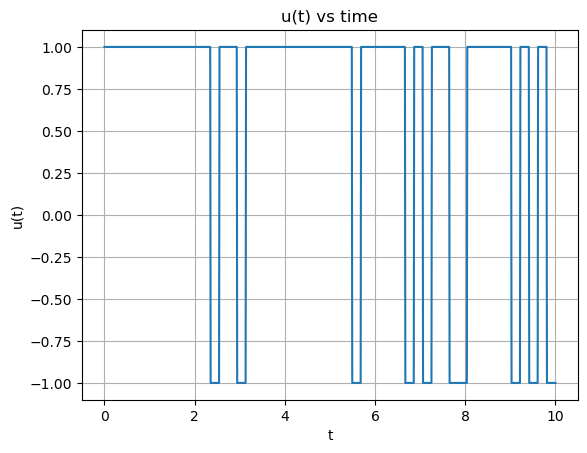

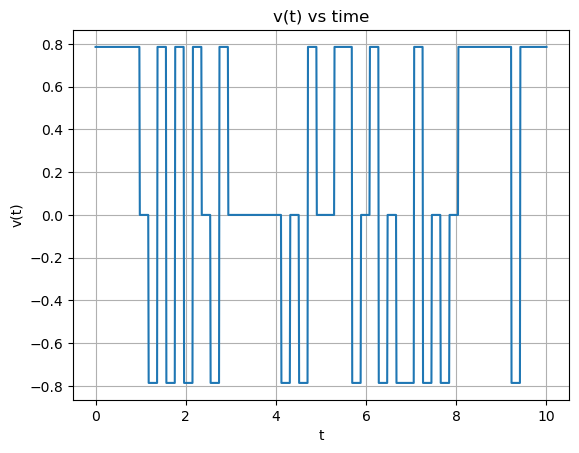

In [92]:
us=[2*(0.5-i%2) for i in u_t]
vs=[(1-i//2)*np.pi/4 for i in u_t]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])
        
x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

## Last Trajectory


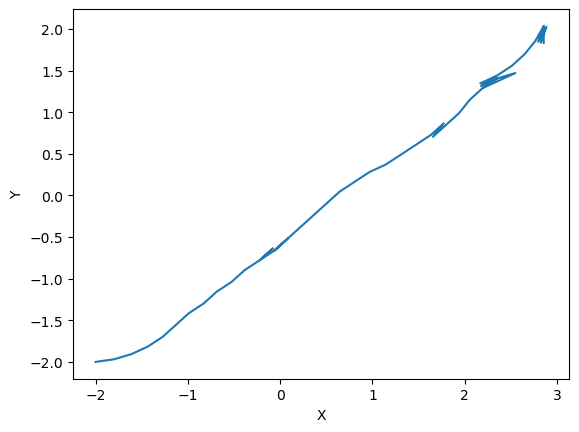

In [93]:
obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

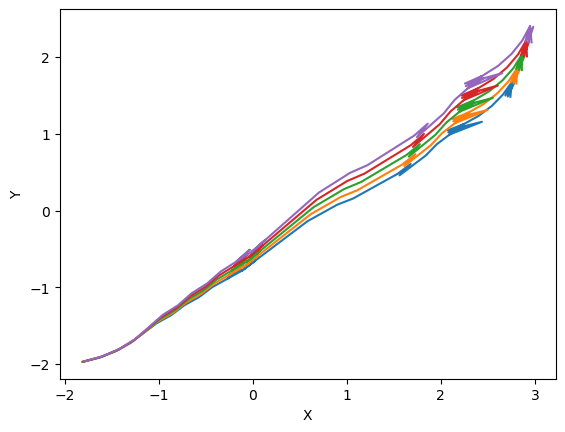

1.4784863795393206


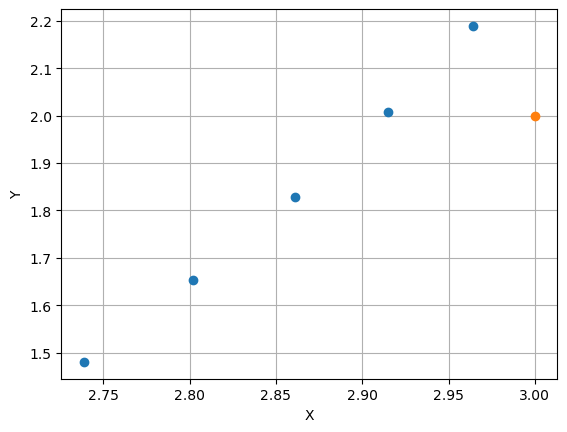

In [94]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()


## Best Trajectory

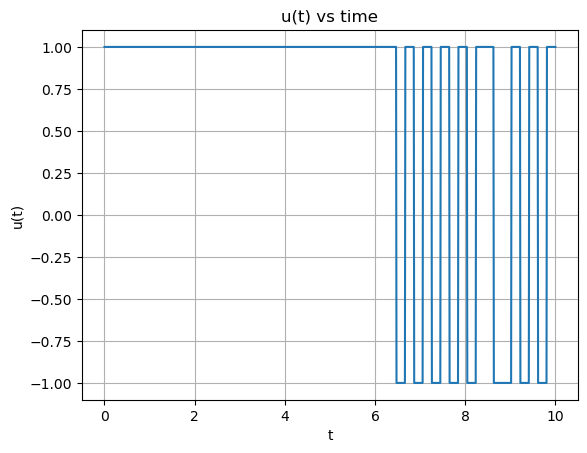

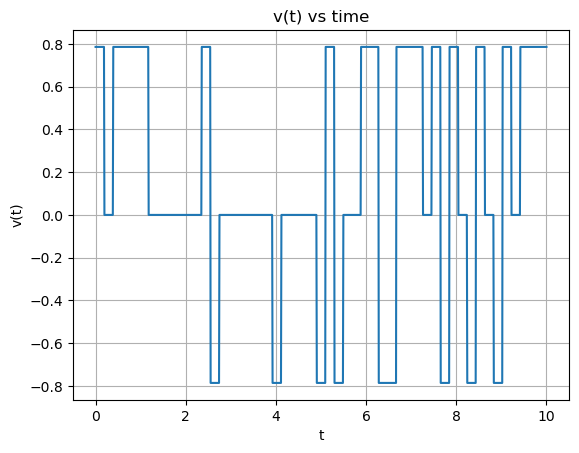

In [95]:
us=[2*(0.5-i%2) for i in best_u]
vs=[(1-i//2)*np.pi/4 for i in best_u]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

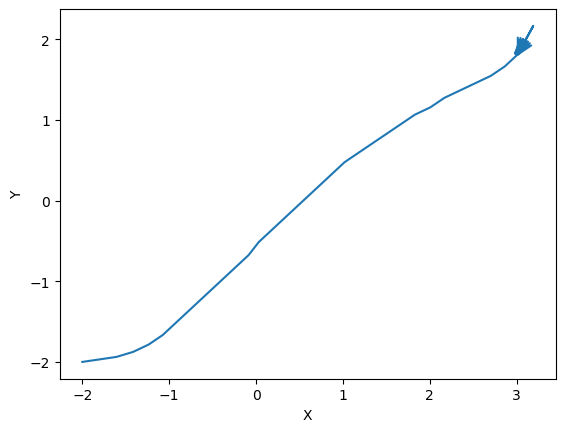

In [96]:
obs=np.array(best_obs)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

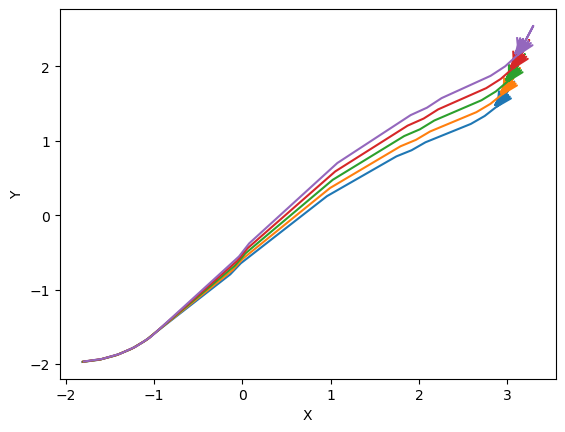

1.142018142845979


In [97]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

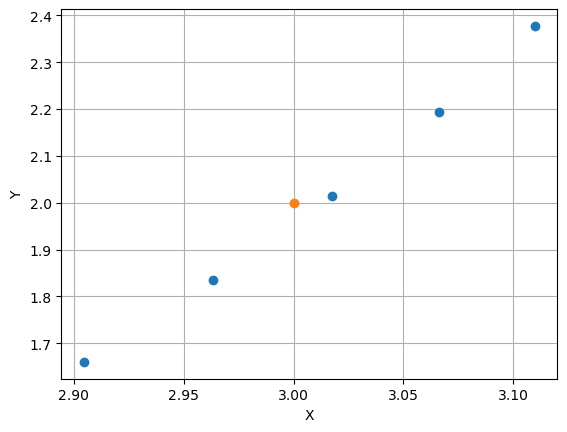

In [98]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    #plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

## Pure Exploitation Trajectory

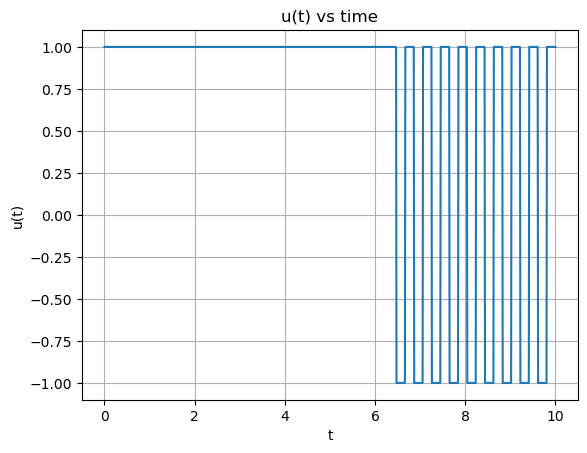

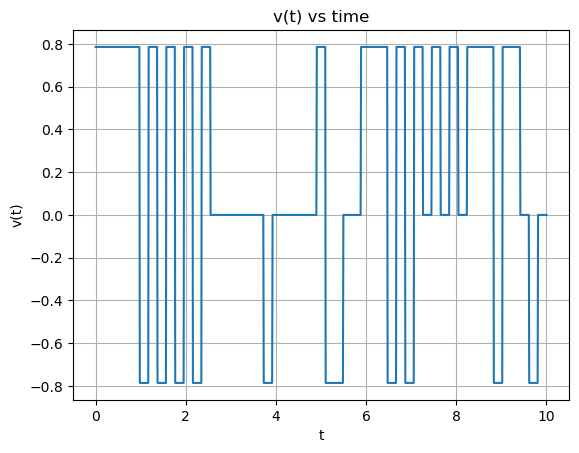

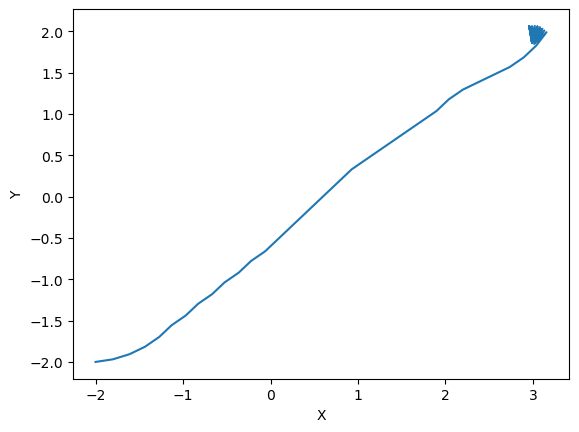

In [99]:
position=np.array([[-2,-2,0] for _ in range(num_system)])
observation=observe(position)
u_t=[]
observation_t=[observation]
position_t=[[] for i in range(num_system)]

for time in range(N+1):           
    
    #print(candidates_u)
    u_k = decide_u_exploitation(gpr_list[time],flags,observation)
    position_new = next_step(position,action_set[u_k])
    observation_new = observe(position_new)
    r = reward(observation_new)
    '''
    if explo:
        history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
        history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
    '''
    observation=observation_new
    position=position_new
    u_t.append(u_k)
    observation_t.append(observation)
    for i in range(num_system):
        position_t[i].append(position[i])
    '''
    if time%((N+1)//3+1)==0:
        for i in range(6):
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[i], history_r[i].reshape(-1,1))
    '''
    
us=[2*(0.5-i%2) for i in u_t]
vs=[(1-i//2)*np.pi/4 for i in u_t]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])
    

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

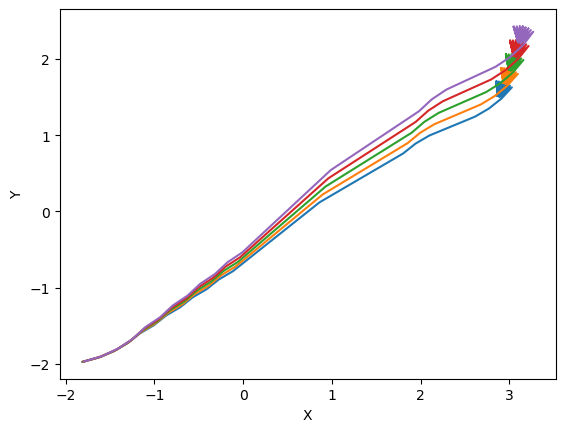

1.2088453580556955


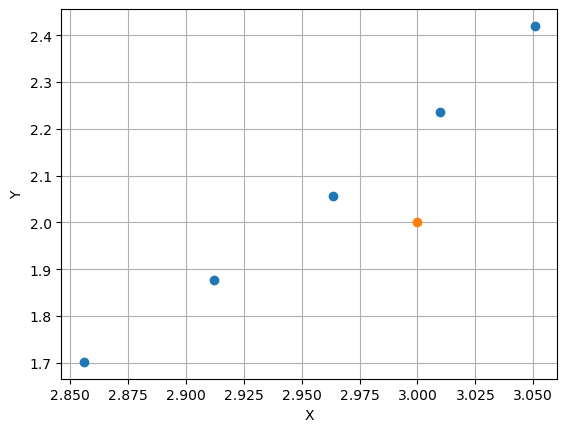

In [100]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(position))

cord_x=[]
cord_y=[]
for i in range(num_system):
    cord_x.append(pos[i][0])
    cord_y.append(pos[i][1])
plt.plot(np.array(cord_x),np.array(cord_y), 'o')
plt.plot(np.array([3]),np.array([2]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()